In [287]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy import stats

# Set precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Data Read

In [288]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            df['year'] = year  # Add the year column 
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

In [289]:
years = [2015, 2016, 2017, 2018, 2019] 
output_directory = "../data/DS/NSDUH"

# Read saved data 
df = pd.concat(read_parquet(output_directory, years).values())   
        

## Sharan Raj Sivakumar Hypothesis

### Hypothesis 1: Early drug use, particularly during adolescence, is a risk factor for the development of mental health issues. 
#### Null Hypothesis: There is no relationship between early drug use and the development of mental health issues.
#### Alternative Hypothesis: Early drug use is associated with an increased risk of developing mental health issues.

In [301]:
identity_columns_H1 = ['QUESTID2']
# drug_usage_columns_H1 = ['MJEVER','MJAGE', 'BLNTEVER', 'BLNTAGE','COCEVER', 'COCAGE', 'CRKEVER', 'CRKAGE', 'HEREVER', 'HERAGE', 'HALLUCEVR','HALLUCAGE', 'METHAMEVR', 'METHAMAGE']

drug_usage_columns_H1 = ['MJAGE', 'BLNTAGE','COCAGE',  'CRKAGE',  'HERAGE', 'HALLUCAGE', 'METHAMAGE']


mental_health_columns_H1 = ['YMDELT']

columns_of_interest_H1 = identity_columns_H1 + drug_usage_columns_H1 + mental_health_columns_H1


In [302]:
# Creating a copy of df for Hypothesis 2 analysis
df_H1 = df[columns_of_interest_H1].copy()

In [303]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 13005143 67415143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  15  14  18 985  12  21  24  17  13  22  35  16  20  19  23  25  36
  38 994   7  30  32   9  11  29  10  27  28  26  31  39   8  37  55  40
  45  34  51  50 998  44  76 997  48  42   5  56  52   6   2  47  43   3
  33   4  54  49  58  72  65  46  57  64  69  62  60  75   1  77  41  78
  74  68  53  61  66  71  67  59  80  63  70  81  79  73  82]

Unique values for BLNTAGE:
[991  26  16  21  14  15 994  18  17  35  19  20  12  13  22  40  36  30
  25  10  23  34  45   6  28  11  56   8  29  24  38  42 997  27  54  32
  31  60  47 981 998   9  55  50   7  37   2  49  48  59  43  53   1  46
 985  33   3  44  41  58  39  52  57  65  51   5  62  66   4  61  63  76
  68  73  64  70  69]

Unique values for COCAGE:
[991  16  13  20  15  24  18  34  19  25  22  17  14  21  27  23  26  12
  50  35  30  37  29  36  28  31 994  38  48 997  39  40  33  32  11 985
   2  55  45 998

In [304]:
# Clean the data
df_H1 = df_H1.drop_duplicates()  # Remove duplicates

In [305]:
df_H1[drug_usage_columns_H1+mental_health_columns_H1].describe()

,MJAGE,BLNTAGE,COCAGE,CRKAGE,HERAGE,HALLUCAGE,METHAMAGE,YMDELT
count,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,66390.00
mean,575.25,763.95,877.24,965.19,974.43,851.72,947.53,1.80
std,481.69,411.66,312.15,155.91,125.60,340.62,200.71,0.40
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,17.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
50%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
75%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
max,998.00,998.00,998.00,998.00,998.00,998.00,998.00,2.00


In [306]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    93: np.nan,
    993: np.nan,
    9993: np.nan,
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan,
    89: np.nan,  
    989: np.nan,
    9989: np.nan,
    85: np.nan, # Bad data
    985: np.nan,
    9985: np.nan
}

# Apply the replacements to the DataFrame
df_H1.replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H1.dropna(inplace=True)

In [307]:
# Convert all to integer
df_H1 = df_H1.astype(int)

In [308]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 70925143 63765143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  14  12  15  17  16  13  11   9  10   8   5   7   2   6   1   3   4]

Unique values for BLNTAGE:
[991  16  14  15  17  12  13  10   8   6 981   7  11   9   1   2   5   3
   4]

Unique values for COCAGE:
[991  15  14  16  17  12  13  10   8   7   9  11   1   6]

Unique values for CRKAGE:
[991  14  15  13  12   8  17  16  11   6]

Unique values for HERAGE:
[991  15  14  13  12   9  16  17  11   5  10]

Unique values for HALLUCAGE:
[991  14  15  17  12  13  16   2   1  10  11   9   8   6   7   4   5]

Unique values for METHAMAGE:
[991  14  15  12  16  17  10  11   9  13   1   8   5   2   6]

Unique values for YMDELT:
[1 2]


In [309]:
# Condition for never used drugs
never_used_condition = (df_H1 == 991) | (df_H1 == 981)

# DataFrame for no drug use
no_drug_use_df = df_H1[never_used_condition[drug_usage_columns_H1].all(axis=1)]
no_drug_use_df["Drug_Use"] = 0

# DataFrame for any drug use
any_drug_use_df = df_H1[~never_used_condition[drug_usage_columns_H1].all(axis=1)]
any_drug_use_df["Drug_Use"] = 1

df_H1 = pd.concat([no_drug_use_df,any_drug_use_df])

# Add a binary column for drug use
# df_H1['Drug_Use'] = ~(df_H1 == 991).all(axis=1) & ~(df_H1 == 981).all(axis=1)


print(f"No Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==0].shape}")

print(f"Any Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==1].shape}")

No Drug Use DataFrame Shape:(53755, 10)
Any Drug Use DataFrame Shape:(11040, 10)


In [310]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(no_drug_use_df['YMDELT'].dropna(), any_drug_use_df['YMDELT'].dropna())

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 43.34074470538926
P-value: 0.0


### Interpretation of Results:

- **T-statistic**: 43.341  
  A **T-statistic** of 43.341 is very large. This indicates that the difference between early drug users and non-drug users (in terms of developing mental health issues) is much greater than what would be expected under the null hypothesis. In other words, this large T-value suggests a strong association between early drug use and the development of mental health issues.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or something extremely close to 0) indicates that the likelihood of observing this data if the null hypothesis were true (i.e., if there really is no association between early drug use and mental health issues) is virtually **zero**.

---

### Conclusion:
- Given the very high T-statistic and the P-value of 0.0, you would **reject the null hypothesis** with great confidence.
- There is very strong evidence to suggest that early drug use, particularly during adolescence, is a significant risk factor for the development of mental health issues.
- The result implies that the observed relationship is not due to random chance but is likely a true effect in the population.

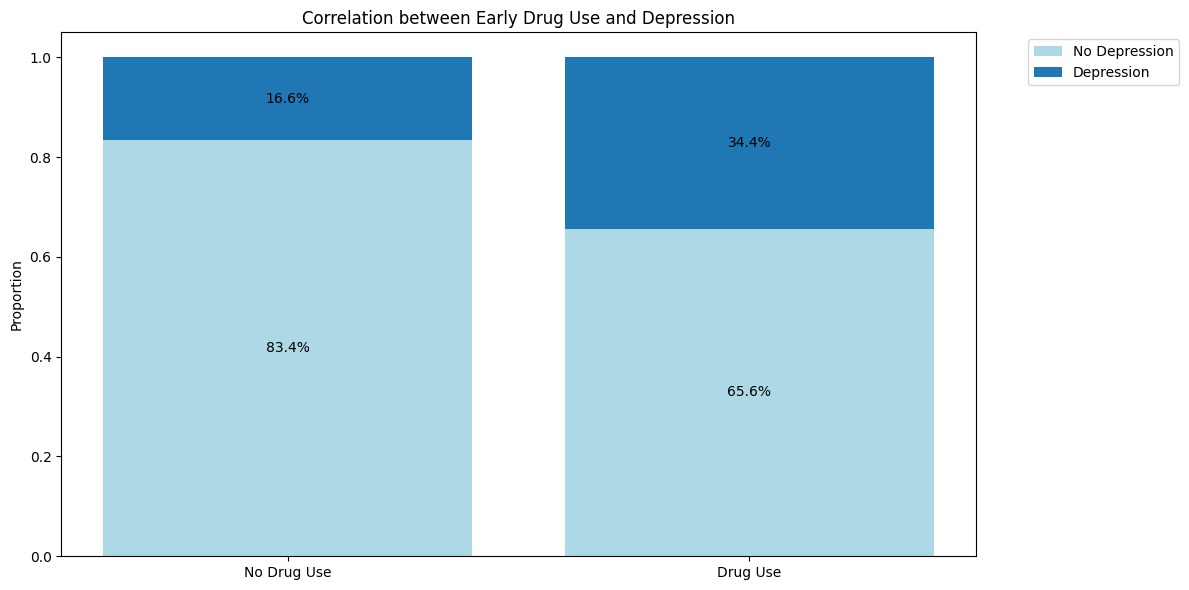

In [311]:
# Calculate the proportions
drug_use_0 = df_H1[df_H1['Drug_Use'] == 0]['YMDELT'].value_counts(normalize=True)
drug_use_1 = df_H1[df_H1['Drug_Use'] == 1]['YMDELT'].value_counts(normalize=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['No Drug Use', 'Drug Use']
no_depression = [drug_use_0.get(2, 0), drug_use_1.get(2, 0)]
depression = [drug_use_0.get(1, 0), drug_use_1.get(1, 0)]

ax.bar(labels, no_depression, label='No Depression', color='lightblue')
ax.bar(labels, depression, bottom=no_depression, label='Depression')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Early Drug Use and Depression')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_dep, dep) in enumerate(zip(no_depression, depression)):
    ax.text(i, no_dep/2, f'{no_dep:.1%}', ha='center', va='center')
    ax.text(i, no_dep + dep/2, f'{dep:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()

### Key Observations:

1. **No Drug Use Group**:
   - **83.4%** of individuals who did not use drugs early are not depressed.
   - **16.6%** of individuals in the "No Drug Use" group suffer from depression.

2. **Drug Use Group**:
   - **65.6%** of individuals who used drugs early are not depressed.
   - **34.4%** of individuals in the "Drug Use" group suffer from depression.

---

### Interpretation:
- **Higher Depression in Drug Users**: The proportion of individuals with depression is notably higher in the "Drug Use" group (**34.4%**) compared to the "No Drug Use" group (**16.6%**).
- **Lower Depression in Non-Drug Users**: Conversely, individuals who did not engage in early drug use show a much higher rate of being non-depressed (**83.4%**) compared to the "Drug Use" group (**65.6%**).

---

### Conclusion:
The chart visually supports the hypothesis that early drug use is associated with a higher likelihood of developing depression. There is a clear difference between the two groups, with a higher proportion of depression among those who used drugs early in life. This suggests that early drug use could be a risk factor for depression, as the relationship is clearly visible in the data.

### Hypothesis 2: Individuals who are married or widowed are less likely to experience suicidal thoughts compared to individuals who are single. 
#### Null Hypothesis: There is no relationship between being marital status and experiencing suicidal thoughts.
#### Alternative Hypothesis: Married or widowed individuals have lesser chance of experiencing suicidal thoughts 

In [312]:
identity_columns_H2 = ['QUESTID2']

independent_columns_H2 = ['IRMARIT']

dependent_columns_H2 = ['SUICTHNK']

columns_of_interest_H2 = identity_columns_H2 + independent_columns_H2 + dependent_columns_H2


In [313]:
# Creating a copy of df for Hypothesis 3 analysis
df_H2 = df[columns_of_interest_H2].copy()

In [314]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
[nan  1.  4.  2. 99.  3.]

Unique values for SUICTHNK:
[99  2 94 97  1 85 98 89]


In [315]:
# Clean the data
df_H2 = df_H2.drop_duplicates()  # Remove duplicates

In [316]:
df_H2[independent_columns_H2+dependent_columns_H2].describe()

,IRMARIT,SUICTHNK
count,224857.00,282003.00
mean,14.22,25.92
std,31.14,41.85
min,1.00,1.00
25%,1.00,2.00
50%,4.00,2.00
75%,4.00,2.00
max,99.00,99.00


In [317]:
# Define a dictionary for replacements based on the code conventions for IRMARIT
code_replacements = {1:"Married", 2:"Widowed", 3:np.nan, 4:"Single", 99: np.nan}


# Apply the replacements to the DataFrame
df_H2["IRMARIT"].replace(code_replacements, inplace=True)


# Define a dictionary for replacements based on the code conventions for SUICTHNK
code_replacements = {85:np.nan, 89:np.nan, 94:np.nan, 97:np.nan, 98:np.nan, 99: np.nan}

# Apply the replacements to the DataFrame
df_H2["SUICTHNK"].replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H2.dropna(inplace=True)

In [318]:
# Convert all to integer
df_H2["SUICTHNK"] = df_H2["SUICTHNK"].astype(int)

In [319]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
['Married' 'Single' 'Widowed']

Unique values for SUICTHNK:
[2 1]


In [320]:
single_df_H2 = df_H2[df_H2["IRMARIT"]=="Single"]
not_single_df_H2 = df_H2[df_H2["IRMARIT"]!="Single"]


In [321]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(not_single_df_H2['SUICTHNK'], single_df_H2["SUICTHNK"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 50.2948528555206
P-value: 0.0


### Results:
- **T-statistic**: 50.295  
  A **T-statistic** of 50.295 is extremely high, indicating a significant difference between the two groups regarding suicidal thoughts. This suggests that the observed data deviate greatly from what would be expected under the null hypothesis.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or very close to it) indicates that the probability of observing such extreme results, assuming the null hypothesis is true, is virtually zero. This strongly suggests that the null hypothesis can be rejected.

---

### Conclusion:
Given the very high T-statistic and the P-value of 0.0, we can confidently **reject the null hypothesis**. There is compelling evidence to support the alternative hypothesis that individuals who are single are significantly more likely to experience suicidal thoughts compared to those who are married or widowed. This result highlights the potential individuals enjoy a sense of companionship(present or former) contributes positively to their happiness.

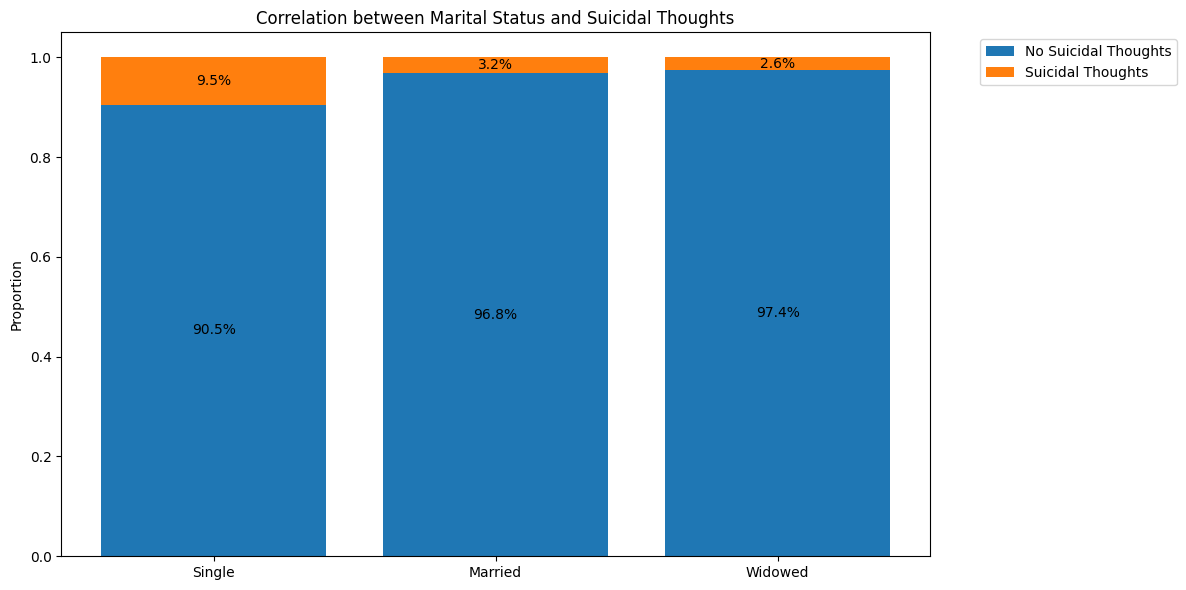

In [322]:
# Calculate the proportions for each marital status
marital_status_0 = df_H2[df_H2['IRMARIT'] == 'Single']['SUICTHNK'].value_counts(normalize=True)
marital_status_1 = df_H2[df_H2['IRMARIT'] == 'Married']['SUICTHNK'].value_counts(normalize=True)
marital_status_2 = df_H2[df_H2['IRMARIT'] == 'Widowed']['SUICTHNK'].value_counts(normalize=True)


# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['Single', 'Married', 'Widowed']
no_suicidal_thoughts = [
    marital_status_0.get(2, 0),  # No for Single
    marital_status_1.get(2, 0),  # No for Marriage
    marital_status_2.get(2, 0),  # No for Widowed
]
suicidal_thoughts = [
    marital_status_0.get(1, 0),  # Yes for Single
    marital_status_1.get(1, 0),  # Yes for Marriage
    marital_status_2.get(1, 0),  # Yes for Widowed
]

ax.bar(labels, no_suicidal_thoughts, label='No Suicidal Thoughts')
ax.bar(labels, suicidal_thoughts, bottom=no_suicidal_thoughts, label='Suicidal Thoughts')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Marital Status and Suicidal Thoughts')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_suicidal, suicidal) in enumerate(zip(no_suicidal_thoughts, suicidal_thoughts)):
    ax.text(i, no_suicidal / 2, f'{no_suicidal:.1%}', ha='center', va='center')
    ax.text(i, no_suicidal + suicidal / 2, f'{suicidal:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()


### Key Observations:

1. **Single Individuals**:
   - **90.5%** of single individuals donot experience having suicidal thoughts.
   - **9.5%** of single individuals experience suicidal thoughts.

2. **Married Individuals**:
   - **96.8%** of married individuals donot experience having suicidal thoughts.
   - **3.2%** of married individuals experience suicidal thoughts.

3. **Widowed Individuals**:
   - **97.4%** of widowed individuals donot experience having suicidal thoughts.
   - **2.6%** of widowed individuals experience suicidal thoughts.

---

### Interpretation:
- **Higher Suicidal Thoughts in Single Individuals**: The proportion of individuals reporting suicidal thoughts is significantly higher in singles compared to married and widowed individual.
---

### Conclusion:
The chart visually supports the hypothesis that marital status is associated with the likelihood of experiencing suicidal thoughts. The data reveals a clear trend, with single individuals showing a higher proportion of suicidal thoughts compared to their married and widowed counterparts. Though Singles do experience higher suicidal thoughts we need to consider other socio-economic factors to further classify since the difference in percentages is less than 7%
